# KDE Heatmaps for NHL Player Shots

I created this project in order to experiment with kernel density estimation heatmaps. The plots do not show a player's quality. Instead, it simply shows the distribution of where certain events take places such as goals, shots, shot attempts, and misses.

An example of what the heatmap should look like is shown below. The example compares where powerplay goals were scored by Alex Ovechkin and Sidney Crosby. However, in order to work with this notebook and develope your own plots it must be run in a Jupyter notebook environment as it is an interactive plot that requires constant communication with the data. So github will not be able to properly display the interactive elements in their system.

It is worth noting that the image used for the rink is not perfectly to scale so there are some discrepancies between the plot and real life. The image was sourced from https://www.peluu.com/features.php.

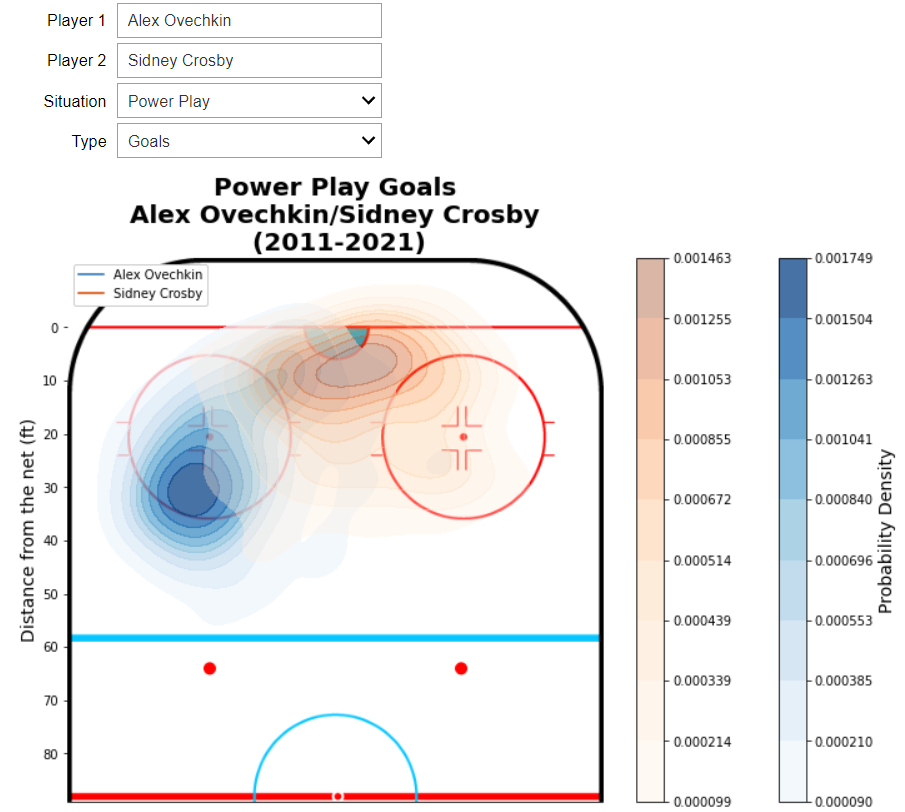

## Shot Dataset

First import all modules to be used, and also read in the dataset. I display the dataset below which contains all Fenwick-based shot attempts from regular season NHL games between the years 2011-2021.
The dataset holds 8 features. 

**GameID** - the unique identifier for the game that the shot attempt took place in. <br>
**Type** - the type of shot attempt (SHOT, MISS, GOAL). <br>
**Strength** - the on-ice strength relative to the team that is taking the shot. <br>
**x** - the x coordinate on the ice standardized to the right side of the ice. <br>
**y** - the y coordinate on the ice standardized to the right side of the ice. <br>
**Team** - the team the player who took the shot plays on. <br>
**Player** - the name of the player who took the shot. <br>
**Outcome** - did the shot result in a goal? (1 = yes, 0 = no) <br>

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import ipywidgets as widgets
from ipywidgets import interact, interact_manual
from scipy import ndimage

#read in the csv
data = pd.read_csv("Database/NHLShotData2011-2019.csv")

#encode the gameID as a string and drop events missing x or y
data['GameID'] = data['GameID'].astype(str)
data = data.dropna(subset=['x', 'y'])

#display the data
display(data)

,GameID,Type,Strength,x,y,Team,Player,Outcome
0,202120001,SHOT,5x5,61.0,-32.0,T.B,STEVEN STAMKOS,0
1,202120001,SHOT,5x5,65.0,-19.0,PIT,BROCK MCGINN,0
2,202120001,SHOT,5x5,8.0,27.0,T.B,JAN RUTTA,0
3,202120001,SHOT,5x5,60.0,4.0,PIT,DANTON HEINEN,0
4,202120001,SHOT,5x5,63.0,4.0,T.B,ONDREJ PALAT,0
...,...,...,...,...,...,...,...,...
1004769,201121230,SHOT,5x5,37.0,-2.0,S.J,BRENT BURNS,0
1004770,201121230,MISS,5x5,78.0,3.0,S.J,JOE PAVELSKI,0
1004771,201121230,MISS,4x4,55.0,-18.0,S.J,TOMMY WINGELS,0
1004772,201121230,MISS,4x4,47.0,15.0,S.J,JUSTIN BRAUN,0


## Player Event Heatmap

This interactive plot is able to compare where two different players shooting events take place. It does not need to compare it will work if only one name is used. The text fields are case insensitive, however, some names may be stored as an abbreviation while others include a player's full name. For example, the database includes Alex Ovechkin (not stored as Alexander Ovechkin) but also stores Mitchell Marner (not stored as Mitch Marner).

In [3]:
def adjustStrength(df,drop):
    """Method used to determine if you should only show 5x5, Power play, or all data.
    
    Parameters:
        df(DataFrame) - the dataframe of shot events.
        drop(String) - the text from the strength dropdown
    
    Returns:
        dataStr(DataFrame) - the data adjusted for strength
    
    """
    if drop == '5v5':
        dataStr = df[df['Strength'] == '5x5']
    elif drop == 'Power Play':
        power = ['5x4','5x3','4x3']
        dataStr = df[df['Strength'].isin(power)]
    else:
        dataStr = df
        
    return dataStr

def eventType(df,drop):
    """Method used to determine if you should only show goals, shots on goal, misses, or all shot events.
    
    Parameters:
        df(DataFrame) - the dataframe of shot events.
        drop(String) - the text from the type dropdown.
    
    Returns:
        dataGoals(DataFrame) - the data adjusted for the type of shot event.
    
    """
    if drop == 'Goals':
        dataGoals = df[df['Outcome'] == 1]
    elif drop == 'Shots on Goal':
        dataGoals = df[df['Type'] == 'SHOT']
    elif drop == 'Missed Shots':
        dataGoals = df[df['Type'] == 'MISS']
    else:
        dataGoals = df
        
    return dataGoals

@interact(text1=widgets.Text(description="Player 1",continuous_update=False),
          text2=widgets.Text(description="Player 2",continuous_update=False),
          drop1=widgets.Dropdown(options=['All','5v5','Power Play'],description='Situation'),
          drop2=widgets.Dropdown(options=['Goals','Shot Attempts','Shots on Goal','Missed Shots'],description='Type'))
def main(text1,text2,drop1,drop2): 
    """Main method used to create the plots
    
    Parameters:
        text1(String) - the text from the player 1 textbox.
        text2(String) - the text from the player 2 textbox.
        drop1(String) - the text from the strength dropdown.
        drop2(String) - the text from the type dropdown.
    """
    #dimensions of rink for our purposes
    minRinkX = 0
    maxRinkX = 102
    minRinkY = -42.5
    maxRinkY = 42.5
        
    #create the figure 
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot()

    #set axis limits
    ax.set_xlim(maxRinkY, minRinkY)
    ax.set_ylim(minRinkX, maxRinkX)

    #read in the image and rotate it
    image = plt.imread('rink2.png')
    image = ndimage.rotate(image,90)
    
    #show image
    ax.imshow((image* 255).astype(np.uint8), extent=[minRinkY, maxRinkY, minRinkX, maxRinkX], aspect='auto')

    #remove the spines from the plot
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_visible(False)

    #set ticks and labels
    ax.set_yticks([9,19,29,39,49,59,69,79,89])
    ax.set_yticklabels(['80','70','60','50','40','30','20','10','0'])
    ax.set_ylabel('Distance from the net (ft)', fontsize=14)
    ax.set_xticks([])
    ax.set_xlabel('')
    
    #split the names
    name1 = text1.split(" ")
    name2 = text2.split(" ")
    
    #if field one is occupied get the name
    if len(name1) > 1:
        #get the player names
        teamOrPlayer1 = name1[0] + " " + name1[1]
    else:
        teamOrPlayer1 = ""
    
    #if field two is occupied get the name
    if len(name2) > 1:
        teamOrPlayer2 = name2[0] + " " + name2[1]
    else:
        teamOrPlayer2 = ""
        
    #make the player names uppercase
    upperTeamOrPlayer1 = teamOrPlayer1.upper()
    upperTeamOrPlayer2 = teamOrPlayer2.upper()
    
    #get all players in the dataset
    allPlayerNames =  data['Player'].unique()
    
    #if only the first field has a player in it
    if (upperTeamOrPlayer1 in allPlayerNames) and not (upperTeamOrPlayer2 in allPlayerNames):
        #update figure size
        fig.set_figheight(8)
        fig.set_figwidth(10)
        
        #get the player name and make it uppercase
        teamOrPlayer = name1[0] + " " + name1[1]
        upperTeamOrPlayer = teamOrPlayer.upper()
        
        #adjust the data for the dropdowns
        tempData = adjustStrength(data,drop1)
        tempData = eventType(tempData,drop2)
        
        #get the data for the individual player
        IndividualData = tempData[(tempData['Player']==upperTeamOrPlayer)]
        
        #make the kde plot edit paramets
        sns.kdeplot(data=IndividualData,x='y',y='x',fill=True,alpha=0.5,cmap='Blues',thresh=.1,cbar=True,cbar_kws={'label': 'Probability Density'},warn_singular=False)
        
        #set the title
        plt.title(drop2 + ' Scoring Heatmap for ' + teamOrPlayer + '\n (2011-2021)', fontsize=20, fontweight="bold")
    
    #if both fields have a player in it
    elif (upperTeamOrPlayer1 in allPlayerNames) and (upperTeamOrPlayer2 in allPlayerNames):
        #update figure size
        fig.set_figheight(8)
        fig.set_figwidth(12)
        
        #adjust the data for the dropdowns
        tempData = adjustStrength(data,drop1)
        tempData = eventType(tempData,drop2)
        
        #get the data for the individual player
        IndividualData1 = tempData[(tempData['Player']==upperTeamOrPlayer1)]
        IndividualData2 = tempData[(tempData['Player']==upperTeamOrPlayer2)]
        
        #make the kde plot edit paramets
        sns.kdeplot(data=IndividualData1,x='y',y='x',cmap='Blues',fill=True,alpha=0.75,thresh=.1,cbar=True,cbar_kws={'label': 'Probability Density'},ax=ax,warn_singular=False)
        sns.kdeplot(data=IndividualData2,x='y',y='x',cmap='Oranges',fill=True,alpha=0.35,thresh=.1,cbar=True,ax=ax,warn_singular=False)
        
        #only have cbar label for one bar
        ax.figure.axes[-2].yaxis.label.set_size(14)
        
        #set the title
        plt.title(drop1 + ' ' + drop2 + '\n' + teamOrPlayer1 + '/' + teamOrPlayer2 + '\n (2011-2021)', fontsize=20, fontweight="bold")
        
        #get the legend colors from the color maps
        cmapP1 = matplotlib.cm.get_cmap('Blues')
        rgbaP1 = cmapP1(0.75)
        cmapP2 = matplotlib.cm.get_cmap('Oranges')
        rgbaP2 = cmapP2(0.75)
        
        #create the legend handles
        p1 = mlines.Line2D([], [], color=rgbaP1, ls='solid', label=teamOrPlayer1)
        p2 = mlines.Line2D([], [], color=rgbaP2, ls='solid', label=teamOrPlayer2)
        
        #plot the legend and make it solid
        legend = plt.legend(handles=[p1, p2],loc='upper left')
        legend.get_frame().set_alpha(None)
    

    plt.show()

interactive(children=(Text(value='', continuous_update=False, description='Player 1'), Text(value='', continuo…